<a href="https://colab.research.google.com/github/cepdnaclk/e19-co544-Bitcoin-Cost-Forecast-System/blob/main/Models/RNN_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Necessary Libraries

In [21]:
import warnings  # Import the warnings module
warnings.filterwarnings("ignore")  # Ignore all warnings

import numpy as np  # Import numpy for numerical computing
import pandas as pd  # Import pandas for data manipulation
import statsmodels.api as sm  # Import statmodels for statistical models
from scipy import stats  # Import stats from SciPy for statistical functions
from sklearn.metrics import mean_squared_error  # Import mean_squared_error from sklearn for model evaluation
from math import sqrt  # Import sqrt from math for square root function
from random import randint  # Import randint from random for generating random integers

from keras.models import Sequential  # Import Sequential from keras for sequential model
from keras.layers import Dense  # Import Dense from keras for fully connected layers
from keras.layers import LSTM  # Import LSTM from keras for LSTM Layers
from keras.layers import GRU  # Import GRU from keras for GRU layers
from keras.callbacks import EarlyStopping  # Import EarlyStopping from keras for early stopping during model training
from keras import initializers  # Import initializers from keras for initializing model parameters

from matplotlib import pyplot as plt  # Import pyplot from matplotlib for plotting
from datetime import datetime  # Import datetime for date and time operations
from datetime import date # Import the date class from the datetime module

import plotly.offline as py  # Import offline module from plotly for offline plotting
import plotly.graph_objs as go  # Import graph_objs from plotly for creating plots
py.init_notebook_mode(connected=True)  # Initialize plotly notebook mode

from sklearn.preprocessing import MinMaxScaler

# %matplotlib inline  # Magic command to display matplotlib plots inline in Jupyter notebooks


# Import the Dataset

In [22]:
import yfinance as yf  # Import the yfinance module, which allows us to download historical market data from yahoo finance

# Define the ticker symbol for BitCoin
ticker = 'BTC-USD'  # Assign the string 'BTC-USD' to the variable 'ticker'.

# Get historical market data
data = yf.Ticker(ticker).history(period = 'max')

# Average Price

In [23]:
# Group the data by the 'Date' column
group = data.groupby('Date')

# Calculate the product of price and volume
data['PV'] = data['Close'] * data['Volume']

# Calculate the cumulative sum of volume
data['cumulative_volume'] = data['Volume'].cumsum()

# Calculate the cumulative sum of PV
data['cumulative_PV'] = data['PV'].cumsum()

# Calculate VWAP
data['Weighted_Price'] = data['cumulative_PV'] / data['cumulative_volume']

Daily_Price = group['Weighted_Price'].mean()

Daily_Price.head()



Date
2014-09-17 00:00:00+00:00    457.334015
2014-09-18 00:00:00+00:00    436.911062
2014-09-19 00:00:00+00:00    419.823580
2014-09-20 00:00:00+00:00    416.734836
2014-09-21 00:00:00+00:00    413.700159
Name: Weighted_Price, dtype: float64

In [24]:
Daily_Price.tail()

Date
2024-05-23 00:00:00+00:00    29803.914960
2024-05-24 00:00:00+00:00    29822.457982
2024-05-25 00:00:00+00:00    29832.465341
2024-05-26 00:00:00+00:00    29842.376433
2024-05-27 00:00:00+00:00    29857.382411
Name: Weighted_Price, dtype: float64

# Split Data

In [25]:
# Define two dates
d0 = date(2014, 9, 17)  # Start date
d1 = date(2024, 5, 27)  # End date

# Calculate the difference between the two dates
delta = d1 - d0  # This will return a time delta object

# Get the number of days from the timedelta object and add 1
days_look = delta.days + 1  # The '+ 1' is to include both end dates in the count

# Print the result
print(days_look)

# Repeat the process for a different date range
d0 = date(2023, 5, 17)
d1 = date(2024, 5, 27)
delta = d1 - d0
days_from_train = delta.days + 1
print(days_from_train)

# Repeat the process for another date range
'''d0 = date(2024, 5, 17)
d1 = date(2024, 5, 21)
delta = d1 - d0
days_from_end = delta.days + 1
print(days_from_end)'''

# Create the training dataset
# The training data is slice from the 'Daily_Price' series. The slice starts from 'days_look' - 'days_from_end' days before thr last record, and ends 'days_from_train' days before the last record.
df_train = Daily_Price[len(Daily_Price) - days_look : len(Daily_Price) - days_from_train]

# Create the testing dataset
# The testing data is a slice from the 'Daily_Price' series. The slice starts from 'days_from_train' days before the last record and includes all records until the end of the series.
df_test = Daily_Price[len(Daily_Price) - days_from_train :]

# Print the length of the training and testing datasets
print(len(df_train), len(df_test))

3541
377
3164 377


# EDA

## Seasonal Decomposition

In [38]:


# Combine the training and testing datasets into a single list
working_data = [df_train, df_test]

# Concatenate the list of dataframes into a single dataframe
working_data = pd.concat(working_data)

# Reset the index of the DataFrame
working_data = working_data.reset_index()

# Convert the 'Date' column to datetime format
working_data['Date'] = pd.to_datetime(working_data['Date'])

# Set the 'Date' column as the index of the DataFrame
working_data = working_data.set_index('Date')

# Perform seasonal decomposition on the 'Weighted_Price' values using a frequency of 60 (assuming daily data)
s = sm.tsa.seasonal_decompose(working_data.Weighted_Price.values, period = 60)

# Create a Scatter plot for the trend component
trace1 = go.Scatter(x = np.arange(0, len(s.trend), 1), y = s.trend, mode = 'lines', name = 'Trend', line = dict(color = ('rgb(244, 146, 65)'), width = 4))

# Create a Scatter plot for the seasonal component
trace2 = go.Scatter(x = np.arange(0, len(s.seasonal), 1), y = s.seasonal, mode = 'lines', name = 'Seasonal', line = dict(color = ('rgb(66, 244, 155)'), width = 2))

# Create a Scatter plot for the residual component
trace3 = go.Scatter(x = np.arange(0, len(s.resid), 1), y = s.resid, mode = 'lines', name = 'Residual', line = dict(color = ('rgb(209, 244, 66)'), width = 2))

# Create a Scatter plot for the observed component
trace4 = go.Scatter(x = np.arange(0, len(s.observed), 1), y = s.observed, mode = 'lines', name = 'Observed', line = dict(color = ('rgb(66, 134, 244)'), width = 2))

# Combine all traces into a list
data = [trace1, trace2, trace3, trace4]

# Define layout settings for the plot
layout = dict(title = 'Seasonal decomposition', xaxis = dict(title = 'Time'), yaxis = dict(title = 'Price, USD'))

# Combine data and layout into a figure
fig = dict(data = data, layout = layout)

# Plot the figure using plotly
py.iplot(fig, filename = 'seasonal_decomposition')

## Autocorrelation

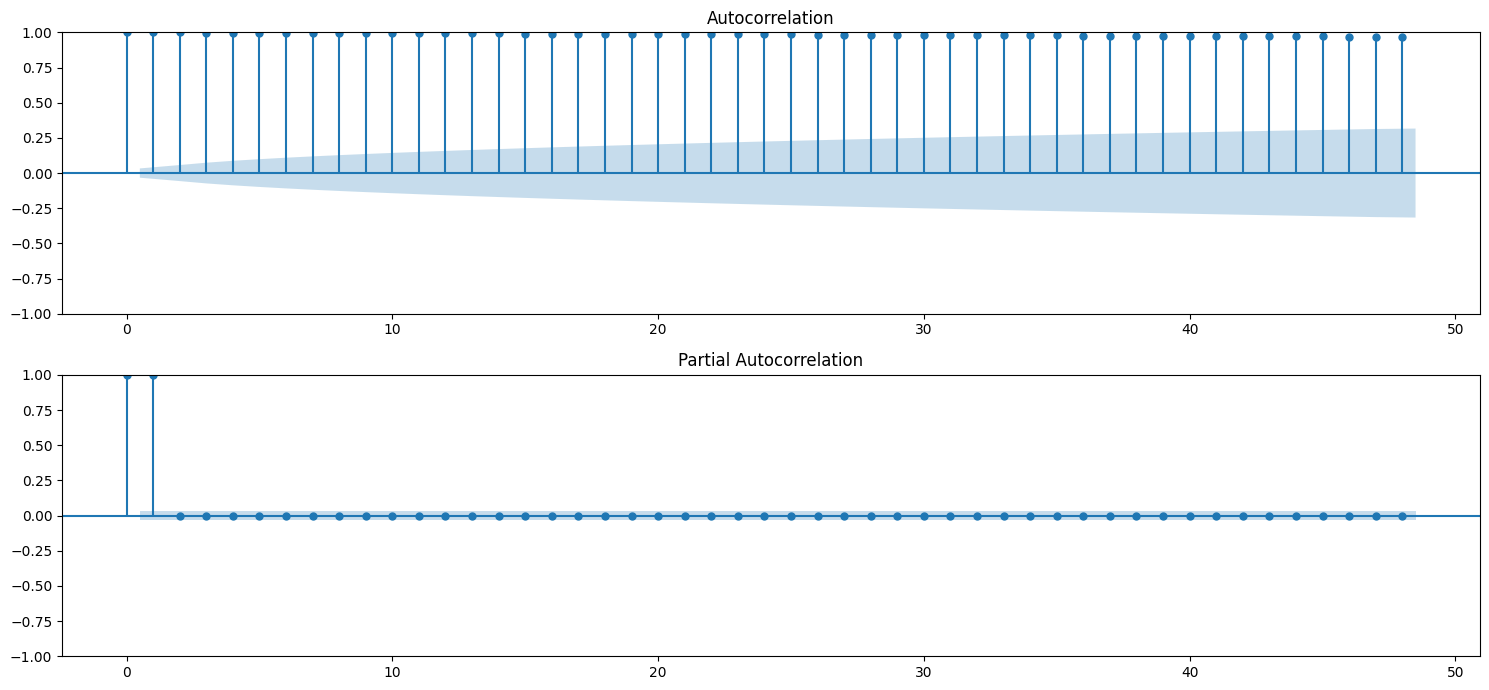

In [27]:
# Set the figure size for the plots
plt.figure(figsize=(15, 7))

# Create the first subplot (Autocorrelation plot)
ax = plt.subplot(211)

# Plot the autocorrelation function (ACF) for the'Weighted_price' values of the working_data
# 'squeeze()' is used to remove single-dimensional entries from the shape of an array
# 'lags=48' specifies the number of lags to include in the plot
sm.graphics.tsa.plot_acf(working_data.Weighted_Price.values.squeeze(), lags = 48, ax = ax)

# Create the second subplot (partial Autocorrelation plot)
ax = plt.subplot(212)

# Plot the partial autocorrelation function (PACF) for the 'Weighted_Price' values of the working_data
sm.graphics.tsa.plot_pacf(working_data.Weighted_Price.values.squeeze(), lags = 48, ax = ax)

# Adjust the layout to prevent overlapping of subplots
plt.tight_layout()

# Display the plots
plt.show()

# Split Training & Test Data

In [28]:
df_train = working_data[ : -60]
df_test = working_data[-60 : ]

# Data Preparation

In [29]:
def create_lookback(dataset, look_back=1):

  # Initialize empty lists to store input sequences (X) and corresponding output values (Y)
  X, Y = [], []

  # Iterate through the dataset, considering each element except the last 'look_back' elements
  for i in range(len(dataset) - look_back):

    # Extract input sequence of length 'look_back' starting from index 'i'
    a = dataset[i:(i + look_back), 0]

    # Append the input sequence to the list of input sequences (X)
    X.append(a)

    # Append the next value in the dataset after the input sequence to the list of output values (Y)
    Y.append(dataset[i + look_back, 0])

  # Convert the lists of input sequences and output values into NumPy arrays
  return np.array(X), np.array(Y)

  # Convert training dataframe to a NumPy array and reshape it to have one feature
  training_set = df_train.values
  training_set = np.reshape(training_set, (len(training_set), 1))

  # Convert test dataframe to a NumPy array and reshape it to have one feature
  test_set = df_test.values
  test_set = np.reshape(test_set, (len(test_set), 1))

  # Initialize MinMaxScaler for scaling datasets to a specified range (usually [0, 1])
  scaler = MinMaxScaler()

  # Scale the training dataset
  training_set = scaler.fit_transform(training_set)

  # Scale the test dataset (using the same scaler as for training)
  test_set = scaler.transform(test_set)

  # Define the number of previous time step to use as input for forecasting
  look_back = 1

  # Create input-output pairs suitable for time series forecasting using the defined look back
  X_train, Y_train = create_lookback(training_set, look_back)
  X_test, Y_test = create_lookback(test_set, look_back)

  # Reshape datasets to fit the requirements of the LSTM model in Keras
  # LSTM model expects input data in the shape [sample, time steps, features]
  X_train = np.reshape(X_train, (len(X_train), 1, X_train.shape[1]))
  X_test = np.reshape(X_test, (len(X_test), 1, X_test.shape[1]))

# Training 2-layers LSTM Neural Network

In [32]:
# Initialize a sequential model
model = Sequential()

# Add the first LSTM layer with 256 units, return the full sequence, and specify the input shape
model.add(LSTM(256, return_sequences=True, input_shape = (X_train.shape[1], X_train.shape[2])))

# Add the second LSTM layer with 256 units, returning only the final output
model.add(LSTM(256))

# Add a densely connected output neuron (Dense layer) with a single unit
model.add(Dense(1))

# Compile the model specifying the loss function and the optimizer
# 'mean_squared_error' is used as the loss function and 'adam' as the optimizer
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

# Fit the model to the training data, specifying the number of epochs, batch size, and validation data
history = model.fit(
    X_train, Y_train,  # Training data
    epochs = 100,  # Number of epochs to train the model
    batch_size = 16,  # Number of samples per gradient update
    shuffle = False,  # Do not shuffle the training data before each epoch
    validation_data = (X_test, Y_test),  # Data on which to evaluate the loss and any model metrics at the end of each epoch
    callbacks = [EarlyStopping(monitor = 'val_loss', min_delta=5e-5, patience = 20, verbose = 1)]  # Early stopping callback
)

# 'EarlyStopping' callback stops training when the validation loss does not improve
# 'monitor' specifies the metric to monitor
# 'min_delta' is the minimum change to qualify as an improvement
# 'patience' is the number of epochs with no improvement after which training will be stopped
# 'verbose' determine the verbosity mode (1 = progress bar)

Epoch 1/100
218/218 [==============================] - 9s 19ms/step - loss: 0.0024 - val_loss: 3.0410e-04
Epoch 2/100
218/218 [==============================] - 3s 15ms/step - loss: 0.0128 - val_loss: 5.2875e-04
Epoch 3/100
218/218 [==============================] - 6s 27ms/step - loss: 0.0085 - val_loss: 1.5320e-04
Epoch 4/100
218/218 [==============================] - 6s 27ms/step - loss: 0.0029 - val_loss: 6.6511e-07
Epoch 5/100
218/218 [==============================] - 4s 18ms/step - loss: 5.0823e-04 - val_loss: 2.4129e-07
Epoch 6/100
218/218 [==============================] - 4s 18ms/step - loss: 7.1626e-05 - val_loss: 1.3521e-06
Epoch 7/100
218/218 [==============================] - 4s 18ms/step - loss: 2.7139e-05 - val_loss: 1.2536e-06
Epoch 8/100
218/218 [==============================] - 3s 14ms/step - loss: 2.3181e-05 - val_loss: 2.2211e-06
Epoch 9/100
218/218 [==============================] - 3s 14ms/step - loss: 2.0532e-05 - val_loss: 4.9804e-07
Epoch 10/100
218/218 [====

# Performance Plot

In [40]:
# Create a scatter plot for the training loss
trace1 = go.Scatter(
    x = np.arange(0, len(history.history['loss']), 1), # X-axis: Epoch numbers
    y = history.history['loss'], # Y-axis: Training loss values
    mode = 'lines', # Line plot
    name = 'Train loss', # Name of the trace
    line = dict(color=('rgb(66, 244, 155)'), width=2, dash='dash') # Line properties: color, width, and dash style
)

# Create a scatter plot for the validation (test) loss
trace2 = go.Scatter(
    x = np.arange(0, len(history.history['val_loss']), 1), # X-axis: Epoch numbers
    y = history.history['val_loss'], # Y-axis: Validation loss values
    mode = 'lines', # Line plot
    name = 'Test loss', # Name of the trace
    line = dict(color=('rgb(244, 146, 65)'), width=2, dash = 'dash') # Line properties: color and width
)

# Combine both traces into a list
data = [trace1, trace2]

# Define the layout of the plot
layout = dict(
    title = 'Train and Test Loss during training', # Title of the plot
    xaxis = dict(title = 'Epoch number'), # X-axis title
    yaxis = dict(title = 'Loss') # Y-axis title
)

# Combine data and layout into a figure
fig = dict(data=data, layout=layout)

# Plot the figure using plotly
py.iplot(fig, filename='training_process')


# Prediction

In [42]:
# Add one additional data point to align shapes of the predictions and true labels
# Transform the last data point in working_data to match the scale of X_test
last_data_point = scaler.transform(working_data.iloc[-1][0].reshape(1, -1))

# Append the transformed last data point to X_test
X_test = np.append(X_test, last_data_point)

# Reshape X_test to fit the LSTM model input shape requirements: [samples, time steps, features]
X_test = np.reshape(X_test, (len(X_test), 1, 1))

# Get predictions from the model using the prepared X_test
prediction = model.predict(X_test)

# Inverse transform the predictions to return them to their original scale in USD
prediction_inverse = scaler.inverse_transform(prediction.reshape(-1, 1))

# Inverse transform the true test labels to return them to their original scale in USD
Y_test_inverse = scaler.inverse_transform(Y_test.reshape(-1, 1))

# Align the prediction and true label arrays by removing the first prediction
# This is because we added an extra data point earlier
prediction2_inverse = np.array(prediction_inverse[:, 0][1:])

# The true labels do not need adjustment, convert to array for consistency
Y_test2_inverse = np.array(Y_test_inverse[:, 0])


2/2 [==============================] - 1s 13ms/step


# Prediction Plot

In [44]:
# Create a scatter plot for the predicted labels
trace1 = go.Scatter(
    x = np.arange(0, len(prediction2_inverse), 1), # X-axis: Day numbers (index of each prediction)
    y = prediction2_inverse, # Y-axis: Predicted prices
    mode = 'lines', # Line plot
    name = 'Predicted labels', # Name of the trace
    line = dict(color=('rgb(244, 146, 65)'), width=2) # Line properties: color and width
)

# Create a scatter plot for the true labels
trace2 = go.Scatter(
    x = np.arange(0, len(Y_test2_inverse), 1), # X-axis: Day numbers (index of each true price)
    y = Y_test2_inverse, # Y-axis: True prices
    mode = 'lines', # Line plot
    name = 'True labels', # Name of the trace
    line = dict(color=('rgb(66, 244, 155)'), width=2) # Line properties: color and width
)

# Combine both traces into a list
data = [trace1, trace2]

# Define the layout of the plot
layout = dict(
    title = 'Comparison of true prices (on the test dataset) with prices our model predicted', # Title of the plot
    xaxis = dict(title = 'Day number'), # X-axis title
    yaxis = dict(title = 'Price, USD') # Y-axis title
)

# Combine data and layout into a figure
fig = dict(data=data, layout=layout)

# Plot the figure using plotly
py.iplot(fig, filename='results_demonstrating0')


In [46]:
Test_Dates = Daily_Price[len(Daily_Price)-days_from_train:].index

trace1 = go.Scatter(x=Test_Dates, y=Y_test2_inverse, name= 'Actual Price',
                   line = dict(color = ('rgb(66, 244, 155)'),width = 2))
trace2 = go.Scatter(x=Test_Dates, y=prediction2_inverse, name= 'Predicted Price',
                   line = dict(color = ('rgb(244, 146, 65)'),width = 2))
data = [trace1, trace2]
layout = dict(title = 'Comparison of true prices (on the test dataset) with prices our model predicted, by dates',
             xaxis = dict(title = 'Date'), yaxis = dict(title = 'Price, USD'))
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='results_demonstrating1')

# RMSE Calculation

In [45]:
RMSE = sqrt(mean_squared_error(Y_test2_inverse, prediction2_inverse))
print('Test RMSE: %.3f' % RMSE)

Test RMSE: 77.543


# GRU Layer

In [74]:
# This function prepares random train/test split,
# scales data with MinMaxScaler, create time series labels (Y)
def get_split(working_data, n_train, n_test, look_back=1):
    # get a point from which we start to take train dataset and after it - test dataset
    start_point = randint(0, len(working_data) - n_test - n_train)
    df_train = working_data[start_point:start_point + n_train]
    df_test = working_data[start_point + n_train:start_point + n_train + n_test]

    training_set = df_train.values
    training_set = np.reshape(training_set, (len(training_set), 1))
    test_set = df_test.values
    test_set = np.reshape(test_set, (len(test_set), 1))

    # scale datasets
    scaler_cv = MinMaxScaler()
    training_set = scaler_cv.fit_transform(training_set)
    test_set = scaler_cv.transform(test_set)

    # create datasets which are suitable for time series forecasting
    X_train, Y_train = create_lookback(training_set, look_back)
    X_test, Y_test = create_lookback(test_set, look_back)

    # reshape datasets so that they will be ok for the requirements of the models in Keras
    X_train = np.reshape(X_train, (len(X_train), 1, X_train.shape[1]))
    X_test = np.reshape(X_test, (len(X_test), 1, X_test.shape[1]))

    return X_train, Y_train, X_test, Y_test, scaler_cv, start_point

# This function takes datasets from the previous function as input and train model using these datasets
def train_model(X_train, Y_train, X_test, Y_test):
    # initialize sequential model, add GRU layer and densely connected output neuron
    model = Sequential()
    model.add(GRU(256, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))

    # compile and fit the model
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, Y_train, epochs=100, batch_size=16, shuffle=False,
              validation_data=(X_test, Y_test), verbose=0,
              callbacks=[EarlyStopping(monitor='val_loss', min_delta=5e-5, patience=20, verbose=0)])
    return model

# This function uses trained model and test dataset to calculate RMSE
def get_rmse(model, X_test, Y_test, scaler, start_point, working_data, n_train):
    # Transform the last data point in working_data to match the scale of X_test
    additional_data_point = scaler.transform(np.array([working_data.iloc[start_point + n_train + len(X_test)]])).reshape(1, 1, 1)

    # Append the additional data point to X_test and reshape to fit the model input shape requirements: [samples, time steps, features]
    X_test = np.append(X_test, additional_data_point, axis=0)
    X_test = np.reshape(X_test, (len(X_test), 1, 1))

    # Get predictions from the model
    prediction = model.predict(X_test)

    # Reshape predictions and Y_test to 2D arrays for inverse transformation
    prediction_inverse = scaler.inverse_transform(prediction.reshape(-1, 1))
    Y_test_inverse = scaler.inverse_transform(Y_test.reshape(-1, 1))

    # Extract the relevant parts of the inverse transformed arrays for RMSE calculation
    prediction2_inverse = np.array(prediction_inverse[:, 0][1:])
    Y_test2_inverse = np.array(Y_test_inverse[:, 0])

    # Calculate RMSE
    RMSE = sqrt(mean_squared_error(Y_test2_inverse, prediction2_inverse))
    return RMSE, prediction2_inverse

In [75]:
def workflow(working_data, get_split, train_model, get_rmse,n_train = 250,n_test = 50,look_back = 1):
    X_train, Y_train, X_test, Y_test, scaler, start_point = get_split(working_data, n_train, n_test)
    model = train_model(X_train, Y_train, X_test, Y_test)
    RMSE, predictions = get_rmse(model, X_test, Y_test, scaler, start_point, working_data, n_train)
    return RMSE, predictions

In [76]:
RMSE, predictions = workflow(working_data, get_split, train_model, get_rmse, n_train = 600,n_test = 60)
print('Test GRU model RMSE: %.3f' % RMSE)

2/2 [==============================] - 0s 10ms/step
Test GRU model RMSE: 5.210


## Cross Validation

In [78]:
# This function is used to repeat the workflow ten times and to calculate average RMSE
def cross_validate(working_data,get_split,train_model,get_rmse,workflow,n_train = 250,n_test = 50,look_back = 1):
    rmse_list = []
    for i in range(10):
        print('Iteration:', i+1)
        RMSE, _ = workflow(working_data, get_split, train_model, get_rmse, n_train, n_test, look_back)
        rmse_list.append(RMSE)
        print('Test RMSE: %.3f' % RMSE)
    mean_rmse = np.mean(rmse_list)
    return mean_rmse, rmse_list

mean_rmse, rmse_list = cross_validate(working_data, get_split, train_model, get_rmse, workflow)
print('Average RMSE: ', mean_rmse)
print('RMSE list:', rmse_list)

Iteration: 1


2/2 [==============================] - 0s 10ms/step
Test RMSE: 104.196
Iteration: 2


2/2 [==============================] - 0s 8ms/step
Test RMSE: 161.417
Iteration: 3
2/2 [==============================] - 0s 7ms/step
Test RMSE: 0.976
Iteration: 4
2/2 [==============================] - 1s 11ms/step
Test RMSE: 417.683
Iteration: 5
2/2 [==============================] - 0s 8ms/step
Test RMSE: 0.161
Iteration: 6
2/2 [==============================] - 0s 7ms/step
Test RMSE: 1.451
Iteration: 7
2/2 [==============================] - 0s 7ms/step
Test RMSE: 3.323
Iteration: 8
2/2 [==============================] - 0s 8ms/step
Test RMSE: 2.585
Iteration: 9
2/2 [==============================] - 1s 9ms/step
Test RMSE: 3.422
Iteration: 10
2/2 [==============================] - 0s 8ms/step
Test RMSE: 10.274
Average RMSE:  70.5487630751106
RMSE list: [104.19556706861249, 161.41706045954606, 0.9757191778881408, 417.6833599481716, 0.16082183696266095, 1.4510723412790683, 3.322637853463892, 2.584806180271313, 3.4221010842555355, 10.274484800655234]


In [79]:
predictions_new = predictions - mean_rmse

RMSE_new = sqrt(mean_squared_error(Y_test2_inverse, predictions_new))
print('Test GRU model RMSE_new: %.3f' % RMSE_new)

Test GRU model RMSE_new: 1519.885


# Prediction Plot

In [80]:
trace1 = go.Scatter(x=Test_Dates, y=Y_test2_inverse, name= 'Actual Price',
                   line = dict(color = ('rgb(66, 244, 155)'),width = 2))
trace2 = go.Scatter(x=Test_Dates, y=predictions_new, name= 'Predicted Price',
                   line = dict(color = ('rgb(244, 146, 65)'),width = 2))
data = [trace1, trace2]
layout = dict(title = 'Comparison of true prices (on the test dataset) with prices our model predicted, by dates',
             xaxis = dict(title = 'Date'), yaxis = dict(title = 'Price, USD'))
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='results_demonstrating2')

## MAPE

In [81]:
def symmetric_mean_absolute_percentage_error(y_true, y_pred, epsilon = 1e-8):
    return np.mean(np.abs(y_pred - y_true) / ((np.abs(y_true) + np.abs(y_pred))/2 + epsilon)) * 100

SMAPE = symmetric_mean_absolute_percentage_error(Y_test2_inverse, predictions_new)

print('Test SMAPE (percentage): %.3f' % SMAPE)

Test SMAPE (percentage): 5.147
